# `PySal` Spatial Regression Models

In [6]:
from pysal.model import spreg
import matplotlib.pyplot as plt
import libpysal as lp
import numpy as np
import pandas as pd

We will use the following libraties from spacebench.

In [2]:
from spacebench import (
    SpaceEnv,
    SpaceDataset,
    DataMaster,
    DatasetEvaluator,
    EnvEvaluator,
)

Load the datamaster to list available datasets

In [3]:
DataMaster().list_datasets()

['healthd_dmgrcs_mortality_disc',
 'cdcsvi_limteng_hburdic_cont',
 'climate_relhum_wfsmoke_cont',
 'climate_wfsmoke_minrty_disc',
 'healthd_hhinco_mortality_cont',
 'healthd_pollutn_mortality_cont',
 'county_educatn_election_cont',
 'county_phyactiv_lifexpcy_cont',
 'county_dmgrcs_election_disc',
 'cdcsvi_nohsdp_poverty_cont',
 'cdcsvi_nohsdp_poverty_disc']

Create the environment.

In [4]:
envname = "healthd_dmgrcs_mortality_disc"
env = SpaceEnv(envname, dir="downloads")
env.__dict__.keys()

dict_keys(['name', 'datamaster', 'api', 'dir', 'config', 'synthetic_data', 'metadata', 'graph', 'confounding_score_dict', 'smoothness_score_dict'])

Example of generating a dataset.

In [5]:
dataset = env.make()
print("treatment shape", dataset.treatment.shape)
print("covariates shape", dataset.covariates.shape)
print("num. edges", len(dataset.edges)) 
print("smoothness of missing confounder", dataset.smoothness_of_missing)
print("confounding of missing confounder", dataset.confounding_of_missing)


treatment shape (3109,)
covariates shape (3109, 30)
num. edges 9237
smoothness of missing confounder 0.9336731373766155
confounding of missing confounder 0.006034317449569775


Now we use pySal models:

In [7]:

W = lp.weights.full2W(dataset.adjacency_matrix()) 

In [8]:
treatment = dataset.treatment[:, None]
covariates = dataset.covariates
outcome = dataset.outcome

# make train matrix
trainmat = np.hstack([covariates, treatment])

In [9]:

model_gm_lag = spreg.GM_Lag(
    outcome,
    trainmat,
    w=W
)

In [11]:
model_ml_lag = spreg.ML_Lag(
    outcome,
    trainmat,
    w=W
)

In [12]:
model_ml_error = spreg.ML_Error(
    outcome,
    trainmat,
    w=W
)

/Users/ant746/PycharmProjects/space/.venv/lib/python3.10/site-packages/spreg/ml_error.py:509: RuntimeWarning: invalid value encountered in log
  jacob = np.log(np.linalg.det(a))


In [13]:
print(model_ml_lag.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     dep_var                Number of Observations:        3109
Mean dependent var  :     21.2983                Number of Variables   :          33
S.D. dependent var  :      4.5544                Degrees of Freedom    :        3076
Pseudo R-squared    :      0.2554
Spatial Pseudo R-squared:  0.2516
Sigma-square ML     :      15.440                Log likelihood        :   -8666.892
S.E of regression   :       3.929                Akaike info criterion :   17399.785
                                                 Schwarz criterion     :   17599.173

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------

In [14]:
model_gm_lag.betas.shape

(33, 1)

Model shape je 33 zato sto ima coefs for: `constant`, `covariates` and `W_outcome`.

In [15]:
trainmat.shape

(3109, 31)

## Predictions

In [141]:
# predict counterfactuals
tvals = dataset.treatment_values
counterfactuals_ml = []
counterfactuals_gm = []
counterfactuals_ml_er = []
for tval in tvals:
    treatment_beta_ml = model_ml_lag.betas[-2]
    treatment_beta_gm = model_gm_lag.betas[-2]
    treatment_beta_ml_er = model_ml_error.betas[-2]

    diff = np.squeeze(tval-treatment, axis=-1)

    counterfactuals_ml.append(outcome + treatment_beta_ml*(diff))
    counterfactuals_gm.append(outcome + treatment_beta_gm*(diff))
    counterfactuals_ml_er.append(outcome + treatment_beta_ml_er*(diff))


counterfactuals_ml = np.stack(counterfactuals_ml, axis=1)
counterfactuals_gm = np.stack(counterfactuals_gm, axis=1)
counterfactuals_ml_er = np.stack(counterfactuals_ml_er, axis=1)

In [142]:
erf_ml = counterfactuals_ml.mean(0)
erf_gm = counterfactuals_gm.mean(0)
erf_ml_er = counterfactuals_ml_er.mean(0)


In [143]:
erf_gm.shape

(2,)

In [146]:
erf_ml

array([20.3812176 , 22.67326486])

In [148]:
erf_ml_er

array([20.3977635, 22.6484593])

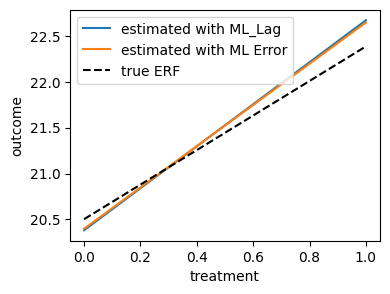

In [149]:
# plot comparing estimated and true erf
erf_true = dataset.erf()

fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.plot(dataset.treatment_values, erf_ml, label="estimated with ML_Lag")
# ax.plot(dataset.treatment_values, erf_gm, label="estimated with GM_Lag")
ax.plot(dataset.treatment_values, erf_ml_er, label="estimated with ML Error")

ax.plot(dataset.treatment_values, erf_true, label="true ERF", linestyle="--", color="k")
ax.set_xlabel("treatment")
ax.set_ylabel("outcome")
ax.legend();